In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr  5 03:58:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 8. Seq2seq으로 번역기 만들기

### ****8-1. Seq2seq 기반 번역기 만들기****

프로젝트는 한국어-영어 말뭉치를 사용 Seq2seq 기반 번역기를 Attention 기법을 추가해서 만듬

In [3]:
import pandas
import tensorflow
import matplotlib

print(pandas.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

1.3.5
2.8.0
3.2.2


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina' 
from pathlib import Path
import matplotlib.font_manager as fm
directory = Path.joinpath(Path.cwd(),'drive','MyDrive','Colab Notebooks','GD','GD-08','data')
fontpath = Path.joinpath(Path.cwd(),'drive','MyDrive','Colab Notebooks','GD','GD-08','NanumBarunGothic.ttf')

# directory = Path.joinpath(Path.cwd(),'data')
# fontpath = 'NanumBarunGothic.ttf'

fp=fm.FontProperties(fname=fontpath)
font_name =fm.FontProperties(fname=fontpath).get_name()
plt.rcParams['font.family'] = font_name

path_to_en_data  = Path.joinpath(directory,'korean-english-park.train.en')
path_to_ko_data  = Path.joinpath(directory,'korean-english-park.train.ko')

In [5]:
import pandas as pd
def load_corpus(path_to_data1, path_to_data2):
    with open(path_to_data1, "r", encoding='UTF-8') as f:
        inputs = f.read().splitlines()        
        
    with open(path_to_data2, "r", encoding='UTF-8') as f:
        outputs = f.read().splitlines()
        
    data = pd.DataFrame(zip(inputs, outputs))
    return data

raw_data = load_corpus(path_to_ko_data, path_to_en_data)
raw_data.columns=['kor','eng']
print('전체 샘플 수 :', len(raw_data))
raw_data.head()

전체 샘플 수 : 94123


,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
import re
import numpy as np

hangul = re.compile('[^ 가-힣]+') # 한글과 띄어쓰기를 제외한 모든 글자

# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    #   sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence) # 가-힣 한글은 지우지 말자.
    
    if remove_stopwords:
        sentence = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        sentence = ' '.join(word for word in sentence.split() if len(word) > 1)

    # sentence =  '<start> ' +  sentence + ' <end>'
    return sentence

In [8]:
!python3 -m pip install konlpy 
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     |████████████████████████████████| 19.4 MB 1.5 MB/s 
     |████████████████████████████████| 448 kB 71.7 MB/s 


In [9]:
from konlpy.tag  import Okt
okt =  Okt()

def make_clean_data(data, n_examples, remove_stopwords=True):
    data.drop_duplicates(subset=['kor'], inplace=True)
    data.drop_duplicates(subset=['eng'], inplace=True)
    data.dropna(how = 'any', inplace=True)
    data.reset_index(drop=True, inplace=True)
    print('중복과 결측치 제거 후 남은 데이터 수',data.shape)
    
    filtered_corpus_kor = []
    filtered_corpus_eng = []
    for i in range(n_examples):  
        kor_txt = preprocess_sentence(' '.join(okt.morphs(data.at[i, 'kor'])), remove_stopwords=False)
        eng_txt = preprocess_sentence(data.at[i, 'eng'])
        
        if kor_txt != '' and eng_txt != '' and kor_txt != 'nan' and eng_txt != 'nan' :
            filtered_corpus_kor.append(kor_txt)
            filtered_corpus_eng.append('<start> ' + eng_txt + ' <end>')
            
    return filtered_corpus_kor, filtered_corpus_eng

In [10]:
data_directory = Path.joinpath(Path.cwd(),'drive','MyDrive','Colab Notebooks','GD','GD-08','data', 'clean_data.csv')
# data_directory = Path.joinpath(Path.cwd(),'data', 'clean_data.csv')

In [11]:
# n_examples = 74848   # 클린 데이터 생성 저장 
# kor_corpus, eng_corpus = make_clean_data(raw_data, n_examples)
# clean_data = pd.DataFrame(zip(kor_corpus, eng_corpus))
# clean_data.columns=['kor','eng']
# clean_data.to_csv(data_directory)

In [12]:
clean_data = pd.read_csv(data_directory)  # 클린 데이터 불러오기
inputs  = list(clean_data['kor'])
outputs = list(clean_data['eng'])

In [13]:
len(inputs)

74826

In [14]:
test_idx = 74800
print("inputs:",  inputs[test_idx])   # <start> 저리 가 ! <end>
print("outputs:", outputs[test_idx])   # <start> go away ! <end>   

inputs: 서킷 시티 올해 까지 전체 매장 폐쇄키 했습니다
outputs: <start> circuit city closing stores end year <end>


****Step 3. 데이터 토큰화****

앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

In [15]:
MIN_LENGTH = 3
MAX_LENGTH = 40 # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
vocab_size = 40000


In [16]:
import tensorflow as tf
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=vocab_size)
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=MAX_LENGTH)
    return tensor, tokenizer

In [17]:

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def length_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for  inputs_, outputs_ in list(zip(inputs, outputs)):
        len_inputs  = len(re.findall(r'\w+', inputs_))
        len_outputs = len(re.findall(r'\w+', outputs_))

        if len_inputs <= MAX_LENGTH and len_outputs <= MAX_LENGTH and \
           len_inputs >= MIN_LENGTH and len_outputs >= MIN_LENGTH + 2: # <start> <end>
            tokenized_inputs.append(inputs_)
            tokenized_outputs.append(outputs_)
    return tokenized_inputs, tokenized_outputs

inputs1, outputs1 = length_filter(inputs, outputs)

In [18]:
# total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
print('데이터 갯수 : ', len(inputs1))
num_tokens = [len(re.findall(r'\w+', tokens)) for tokens in inputs1]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 최소 : ', np.min(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

데이터 갯수 :  73620
문장길이 평균 :  15.59550393914697
문장길이 최대 :  40
문장길이 최소 :  3
문장길이 표준편차 :  6.3421586430637165


In [19]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(inputs1)
dec_tensor, dec_tokenizer = tokenize(outputs1)

In [20]:
enc_tensor[2]
# print(test_enc)
# sentence = enc_tokenizer.sequences_to_texts(test_enc)
# # print(sentence[0])

array([  37,   89, 6841,  726,   35,  589,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [21]:
dec_tensor[2]

array([    1,    74, 12926,  4520,    13,   334,  6379,     2,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [22]:
for i in range(1,10):
    print('{}:{}'.format(i,enc_tokenizer.index_word[i]))

1:했다
2:에서
3:으로
4:있다
5:하고
6:하는
7:밝혔다
8:미국
9:이라고


In [23]:
for i in range(1,10):
    print('{}:{}'.format(i,dec_tokenizer.index_word[i]))

1:<start>
2:<end>
3:said
4:people
5:year
6:two
7:one
8:new
9:president


In [24]:
from sklearn.model_selection import train_test_split
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import time
import io

# 훈련 데이터와 검증 데이터로 분리하기
# enc_train, enc_val, dec_train, dec_val = \
# train_test_split(enc_tensor, dec_tensor, test_size=0.1)

enc_train = enc_tensor  # 안한다
dec_train = dec_tensor

In [25]:
print("Korean  Vocab Size:", vocab_size)
print("English Vocab Size:", vocab_size)

Korean  Vocab Size: 40000
English Vocab Size: 40000


****Step 5. 훈련하기****

훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

❕ 참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

In [26]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [27]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        self.gru1 = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        out = self.gru1(out)
        
        return out

In [28]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.gru1 = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        out, h_dec = self.gru(out)
        out, h_dec = self.gru1(out)

        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [29]:
BATCH_SIZE    = 1024
units         = 256
embedding_dim = 512

SRC_VOCAB_SIZE = vocab_size + 1
TGT_VOCAB_SIZE = vocab_size + 1


encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = MAX_LENGTH

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)



Encoder Output: (1024, 40, 256)
Decoder Output: (1024, 40001)
Decoder Hidden State: (1024, 256)
Attention: (1024, 40, 1)


In [30]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  20480512  
                                                                 
 gru (GRU)                   multiple                  591360    
                                                                 
 gru_1 (GRU)                 multiple                  394752    
                                                                 
Total params: 21,466,624
Trainable params: 21,466,624
Non-trainable params: 0
_________________________________________________________________


In [31]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  20480512  
                                                                 
 gru_2 (GRU)                 multiple                  787968    
                                                                 
 gru_3 (GRU)                 multiple                  394752    
                                                                 
 dense (Dense)               multiple                  10280257  
                                                                 
 bahdanau_attention (Bahdana  multiple                 131841    
 uAttention)                                                     
                                                                 
Total params: 32,075,330
Trainable params: 32,075,330
Non-trainable params: 0
_______________________________________________

### ****8-4. 훈련하기 (1) Optimizer & Loss****

Encoder-Decoder 구조에서 학습 과정을 정의

**Optimizer & Loss**

In [32]:
# optimizer = tf.keras.optimizers.Adam()
optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # 0이 아닌부분 마스크??
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

`mask` 는 `<PAD>` 토큰을 찾아내어 그 부분에 대한 Loss를 구하지 않도록 함.

### ****8-5. 훈련하기 (2) train_step 구현하기****

In [33]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


In [34]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

In [35]:
import os
# checkpoint_dir = './training_checkpoints'
checkpoint_dir = Path.joinpath(Path.cwd(),'drive','MyDrive','Colab Notebooks','GD','GD-08','training_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [36]:
## 체크포인트 불러오기
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [37]:
# Training Process
import random
from tqdm import tqdm

EPOCHS = 300

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
  # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)        
    
#     test_loss = 0
    
#     idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
#     random.shuffle(idx_list)
#     t = tqdm(idx_list)

#     for (test_batch, idx) in enumerate(t):
#         test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
#                                     dec_val[idx:idx+BATCH_SIZE],
#                                     encoder,
#                                     decoder,
#                                     dec_tokenizer)
    
#         test_loss += test_batch_loss

#         t.set_description_str('Test Epoch %2d' % (epoch + 1))
#         t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Epoch 300: 100%|██████████| 72/72 [01:14<00:00,  1.03s/it, Loss 0.1628]


In [38]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    
    sentence = preprocess_sentence(sentence, remove_stopwords=False)
    sentence = ' '.join(okt.morphs(sentence))
    
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                    maxlen=enc_train.shape[-1],
                                                    padding='post')
    
    sentence = enc_tokenizer.sequences_to_texts(inputs) # 번역기에 실제 들어가는 문장
    sentence = sentence[0]
    
    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict,fontproperties=fp, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict,fontproperties=fp)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))



Input: 오바마 대통령 이다
Predicted translation: president elect going <end> 


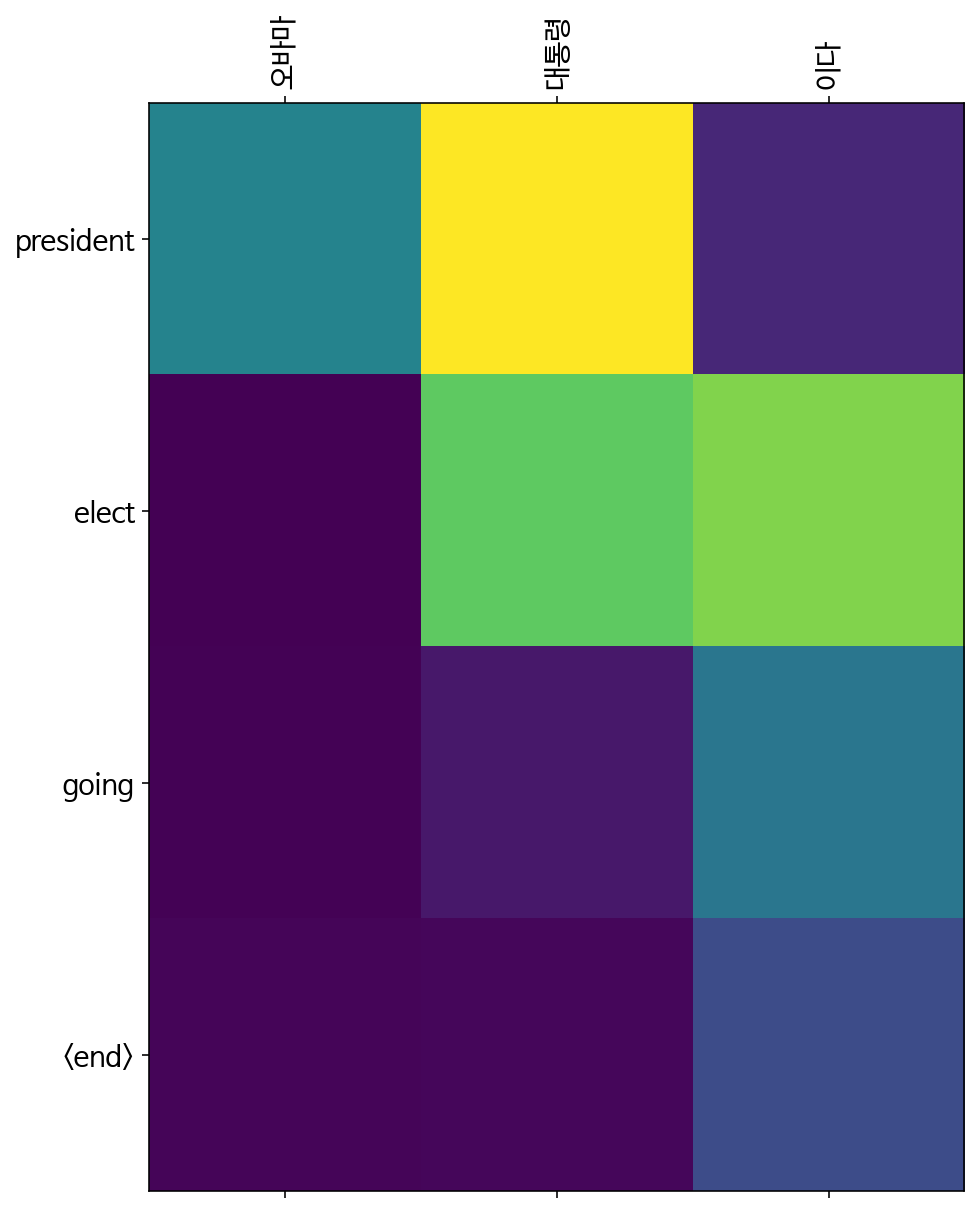

In [39]:
translate('오바마는 대통령이다.', encoder, decoder)

Input: 시민 도시
Predicted translation: total control square places <end> 


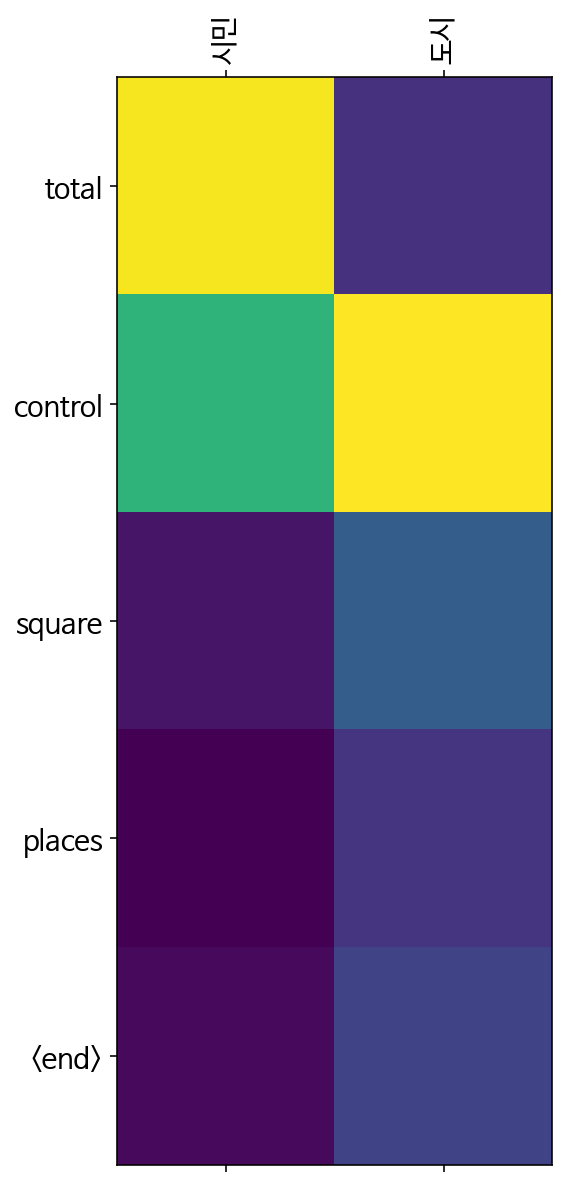

In [40]:
translate('시민들은 도시 속에 산다.', encoder, decoder)

Input: 커피 필요 없다
Predicted translation: important experts saying <end> 


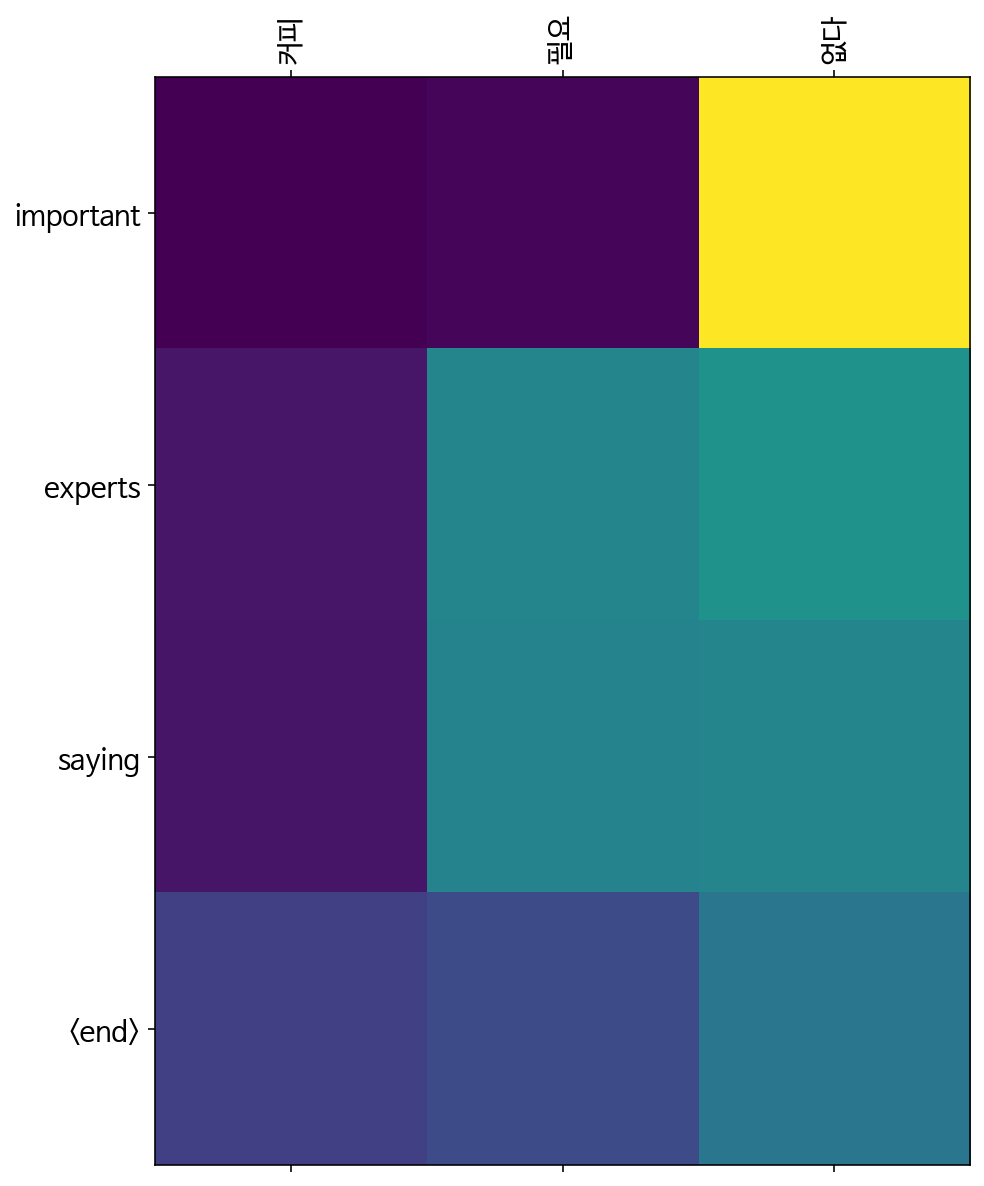

In [41]:
translate('커피는 필요 없다.', encoder, decoder)

Input: 일곱 명의 사망자 발생 했다
Predicted translation: since injuries killed <end> 


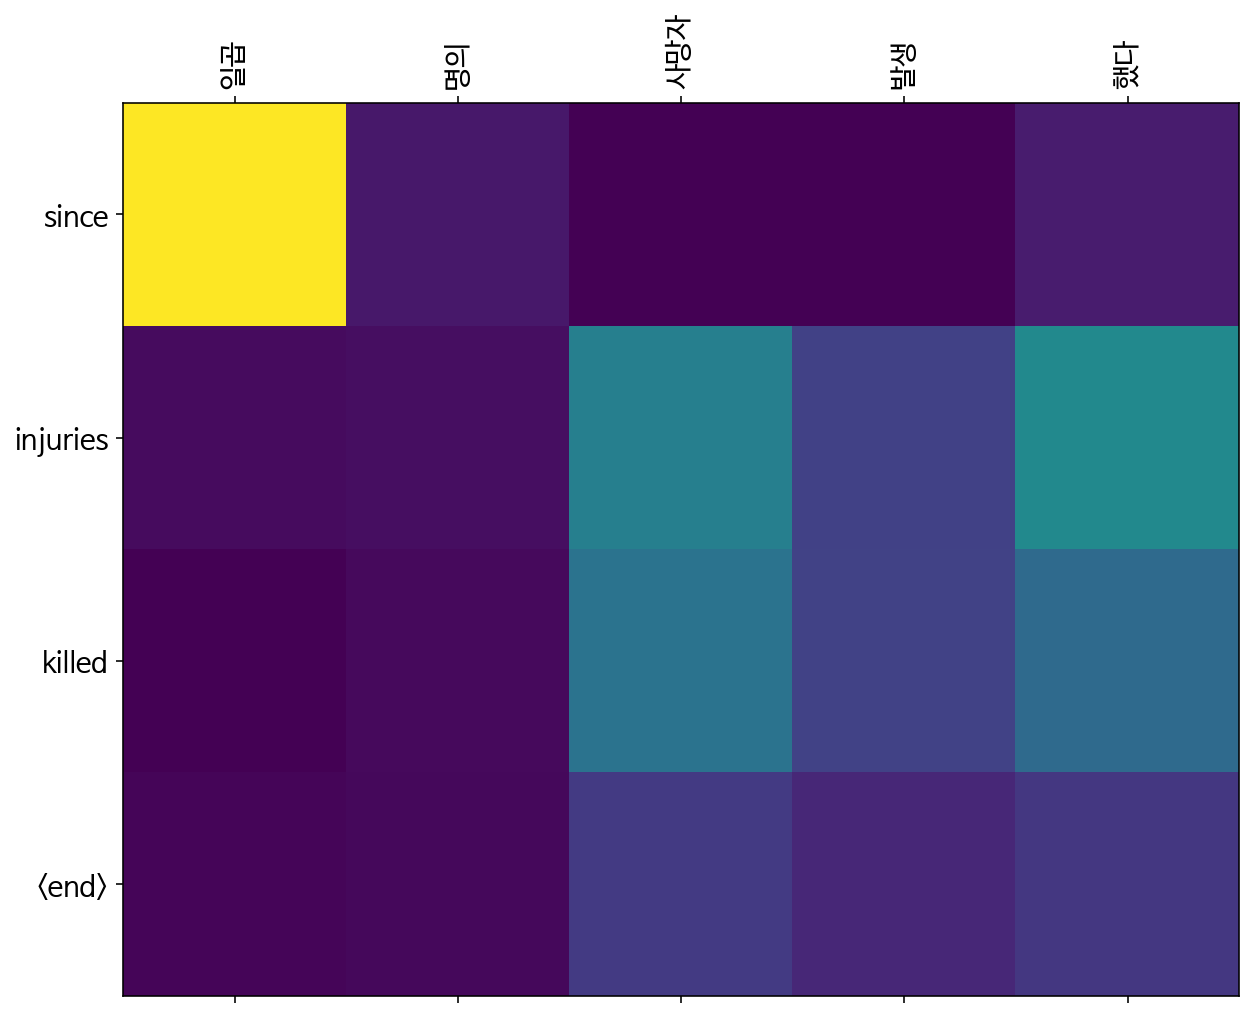

In [42]:
translate('일곱 명의 사망자가 발생했다.', encoder, decoder)

In [43]:
sentence = '시민들은 도시 속에 산다.'

sentence = preprocess_sentence(sentence, remove_stopwords=False)
print(sentence.split())
sentence = ' '.join(okt.morphs(sentence))
print(sentence.split())
print(sentence)
inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
print(inputs)
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                       maxlen=enc_train.shape[-1],
                                                       padding='post')
print(inputs)
input_test = enc_tokenizer.sequences_to_texts(inputs)
print(*input_test)

['시민들은', '도시', '속에', '산다']
['시민', '들', '은', '도시', '속', '에', '산다']
시민 들 은 도시 속 에 산다
[[521, 232]]
[[521 232   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]
시민 도시


Input: 교수 뉴욕 출신 이며 캠브리지 대학 에서 생리학 으로 박사학위 받았다
Predicted translation: tsien born new york received ph physiology cambridge university <end> 


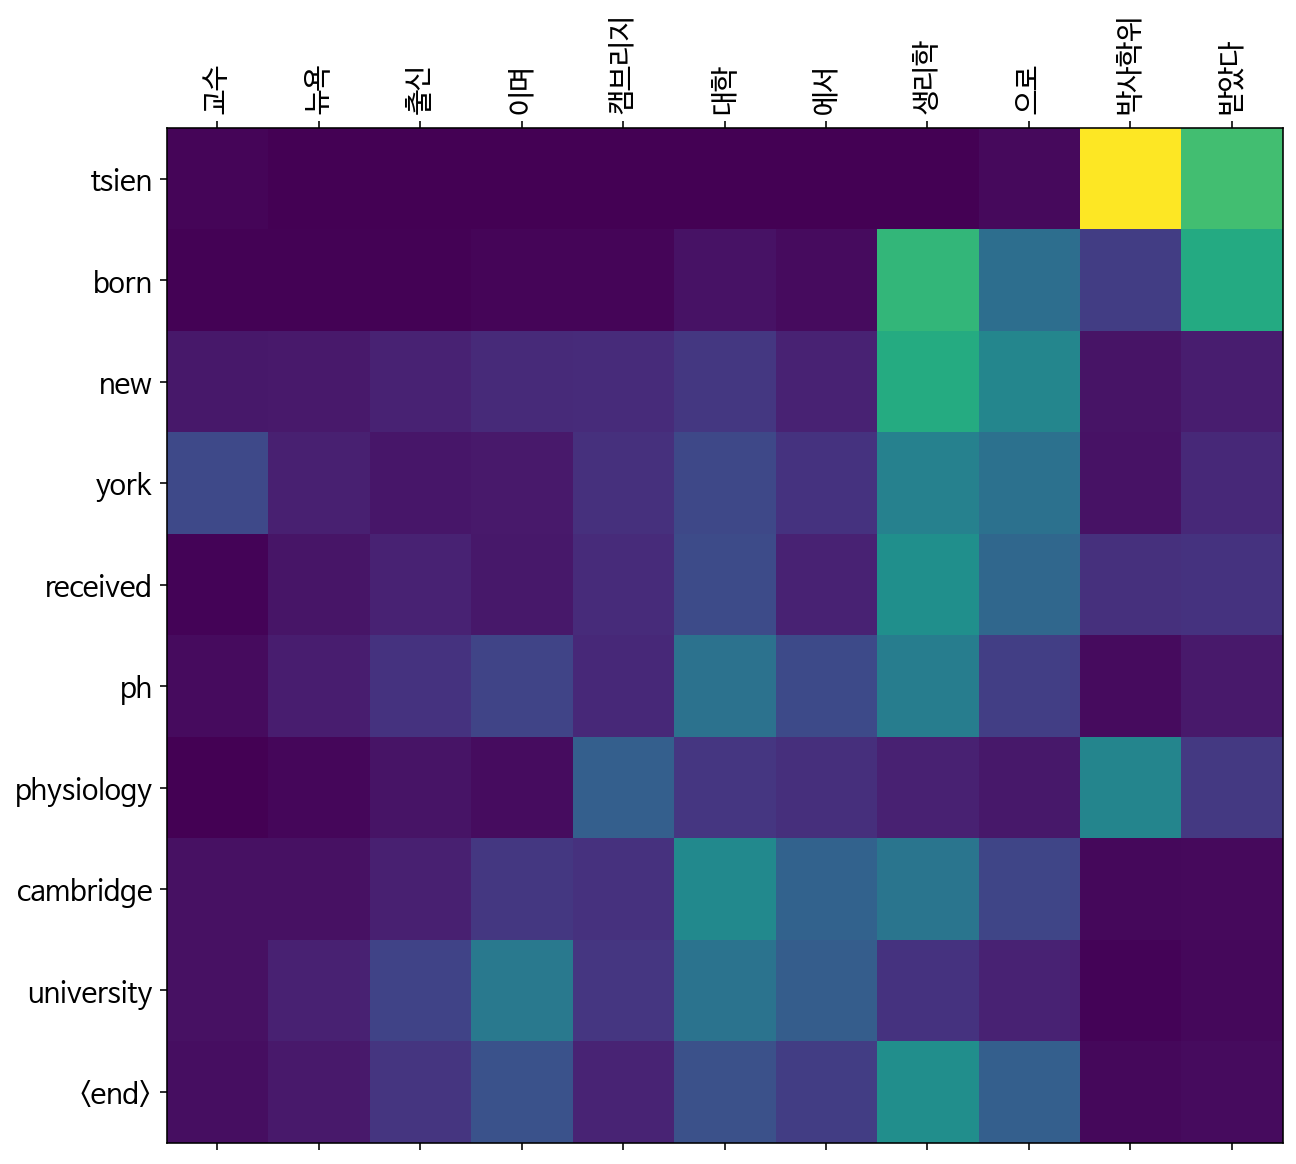

In [46]:
translate('교수는 뉴욕 출신이며 캠브리지 대학에서 생리학으로 박사학위를 받았다', encoder, decoder)

## 후기 :  
  
#### BATCH_SIZE      = 1024
#### units                    = 256
#### embedding_dim = 512
#### GRU를 인코더 디코더에 각각 2 layer 사용했고 drop은 사용하지 않았다.
  
#### MIN_LENGTH = 3 짧은 문장 중에 번역문과 일치하지 않는 내용이 있어 커트
#### MAX_LENGTH = 40 # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
#### vocab_size = 40000 으로 계산했다.

#### 토큰화 과정에서
#### 영어는 tf.keras.preprocessing.text.Tokenizer
#### 한글은 Okt를 사용했다.
#### 한글에 Sentencepiece를 사용해 보았는데 한편으로는 규칙이 있게 분리되면서 한편으로는 무작위로 분리가 되었다.
#### 데이터가 많으면 좀더 나은 성능을 보일 것이라고 기대한다. 

#### 예시문이 어떤 문장으로 변환되어 입력이 되는지 확인해 봤다.
#### 예문을 Okt를 사용해서 토큰화 시킨후 다시 문장으로 돌리면 이렇게 된다.
#### 오바마는 대통령이다. -> 오바마 대통령 이다 
#### 시민들은 도시 속에 산다. -> 시민 도시
#### 커피는 필요 없다. -> 커피 필요 없다
#### 일곱 명의 사망자가 발생했다. -> 일곱 명의 사망자 발생 했다
#### 번역결과는 위에 있다.

#### 혹시나 해서 데이터에 있는 문장 하나를 꺼내 번역을 해보았다.

#### '교수는 뉴욕 출신이며 캠브리지 대학에서 생리학으로 박사학위를 받았다.'
#### tsien born new york received ph physiology cambridge university
#### 뉴욕 : new york  출신 : born 캠브리지 대학 : cambridge university 
#### 생리학 박사학위 : ph physiology 받았다 : received 교수 : tsien(???)
#### 보면  갖추어야할 단어는 대부분 갖추었는데 무언가 어색하다.
#### 아니 필요없다고 빼버린 불용어를 집어넣으면 이렇게 될 것 같다.
#### tsien (The professor) (was) born (in) New York (City) (and) received (a) Ph(.D.) (in) physiology (from) Cambridge University.
#### 이렇게 보니 불용어가 불용어가 아닌 것이다.
#### 그런데 불용어를 제거하지 않고 돌리면 수많은 the the the the the를 만나게 될 것이다. 모든 단어는 the로 치환된다.

####  대책없이 GRU layer을 3 이상으로 올리면 loss가 줄어들지 않았다.